In [1]:
using Pkg
Pkg.activate("C:/Users/lisah/Documents/Repos/ma-code")

  Activating project at `C:\Users\lisah\Documents\Repos\ma-code`


In [2]:
using DifferentialEquations, CSV, DataFrames, Plots, Distributions, ForwardDiff, LinearAlgebra, Random

### tools

In [3]:
# functions that remain unchanged

function create_grid()
    a_vals = 0.0:0.1:2.0
    n_vals = 0.0:0.1:4.0

    grid = [(a, n) for n in n_vals, a in a_vals] 
    return grid
end

function randomize_data(df::DataFrame, noise::Float64)
    if noise == 0.0
        return df
    else
        Random.seed!(1) # make it reproducible
        df[!, "w"] .= df[!, "w"] .+ rand(Normal(0, noise), nrow(df))
        df[!, "n"] .= df[!, "n"] .+ rand(Normal(0, noise), nrow(df))
        return df
    end
end

abstract type AbstractHyperprm end

struct Hyperprm <: AbstractHyperprm
    w0::Real
    n0::Real
    a::Real
    m::Real
    M::Real
    noise::Real
end

"""define the klausmeier model equations
"""
function klausmeier!(du,u,p,t)
    du[1] = -u[1] - u[1] * u[2]^2 + p[1] # water compartment
    du[2] = u[1] * u[2]^2 - p[2] * u[2] # biomass compartment
end

"""solves the klausmeier model for given set of parameters
"""
function sol_klausmeier(hprm::Hyperprm; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0)
    u0 = [hprm.w0; hprm.n0]
    p = [hprm.a; hprm.m]

    if t_fixed
        tspan = (0.0, t_end)
        prob = ODEProblem(klausmeier!, u0, tspan, p)
        steps = range(0.0, stop=t_end, length=hprm.M)
        sol = solve(prob,
            saveat=steps  # consider specific time points
        )
    else
        tspan = (0.0, hprm.M-1)
        prob = ODEProblem(klausmeier!, u0, tspan, p)
        sol = solve(prob,
            saveat=t_step  # consider specific time points
        )
    end
    return DataFrame(time=sol.t, w=sol[1, :], n=sol[2, :])
end

sol_klausmeier

In [4]:
function compute_ll(x, hprm::Hyperprm, true_val::DataFrame; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0)
    a, n0 = x
    hprm = Hyperprm(hprm.w0, n0, a, hprm.m, hprm.M, hprm.noise)
    pred_val = sol_klausmeier(hprm; t_fixed=t_fixed, t_end=t_end, t_step=t_step)
    if hprm.noise == 0.0 # then compute expected fisher info
        ll = -0.5 * sum((true_val[:,"n"] - pred_val[:,"n"]) .^2) - 0.5 * sum((true_val[:,"w"] - pred_val[:,"w"]) .^2) # add up ll for both trajectories
    else
        ll = -0.5 * 1/hprm.noise * sum((true_val[:,"n"] - pred_val[:,"n"]) .^2) - 0.5 * 1/hprm.noise * sum((true_val[:,"w"] - pred_val[:,"w"]) .^2) # add up ll for both trajectories
    end
    return ll
end

compute_ll (generic function with 1 method)

### analysis

In [5]:
M_vals = [1000]
noise_vals = [0.0]
w0 = 0.95
m = 0.45

0.45

In [6]:
# define points where i want to analyze inverse hessian
a_vals = [0.1, 0.9, 1.1, 1.3, 1.7] 
n_vals = [0.2, 0.4, 1.0, 1.3, 2.3]
points = [[a_vals[1],n_vals[2]], [a_vals[2],n_vals[4]], [a_vals[3],n_vals[5]], [a_vals[5],n_vals[3]], [a_vals[4],n_vals[1]], [a_vals[2],n_vals[2]]]

6-element Vector{Vector{Float64}}:
 [0.1, 0.4]
 [0.9, 1.3]
 [1.1, 2.3]
 [1.7, 1.0]
 [1.3, 0.2]
 [0.9, 0.4]

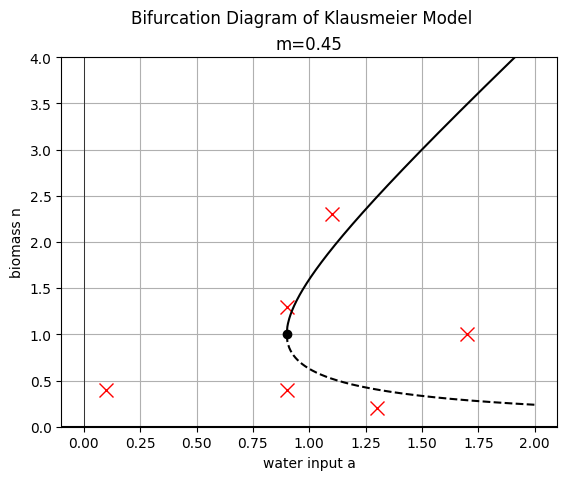

In [8]:
for M in M_vals
    for noise in noise_vals
        for pt in points
            hprm = Hyperprm(w0, pt[2], pt[1], m, M, noise) #w0,n0,a,m,M

            sol_true = sol_klausmeier(hprm; t_fixed=true, t_end=500.0) # returns df
            sol_true = randomize_data(sol_true, hprm.noise) # include noise

            x = [hprm.a, hprm.n0]
            H = ForwardDiff.hessian(x -> compute_ll(x, hprm, sol_true; t_fixed=false), x)
            Sigma = inv(H)
            display(Sigma)
        end
    end
end

2×2 Matrix{Float64}:
 -0.00100234  -0.00011528
 -0.00011528  -0.351146

2×2 Matrix{Float64}:
 -3.83781e-8   4.84073e-7
  4.84073e-7  -0.171692

2×2 Matrix{Float64}:
 -0.000107119   0.000199856
  0.000199856  -0.439022

2×2 Matrix{Float64}:
 -0.000171626   0.000447249
  0.000447249  -0.368654

2×2 Matrix{Float64}:
 -0.00100259  -0.00047965
 -0.00047965  -0.504493

2×2 Matrix{Float64}:
 -0.00100607   -0.000822414
 -0.000822414  -0.251307